### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
# %%time
# p = '../tempNNhierTheory/'
# p1 = 'tempNNhierTheory/'

# base_path = '../results/'+p1

# treated = pd.read_pickle(p+'treated2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
# controls = pd.read_pickle(p+'matched.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

# treated['Treatment'] = 1
# controls['Treatment'] = 0

In [5]:
%%time
folder_name = "MHTM_g/"
p = '../Final/Data/' + folder_name
p1 = '../Pre_Matching_DATA/'

base_path = '../Final/results/'+ folder_name

treated = pd.read_pickle(p1+'treated2Past2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'matched_controls_original.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 254 ms, sys: 159 ms, total: 414 ms
Wall time: 438 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [6]:
treated.MYR.min()

201710

In [7]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [8]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [9]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [10]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [11]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.2 s, sys: 23.9 ms, total: 12.2 s
Wall time: 12.2 s


In [12]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 94 columns]

In [13]:
survTr.shape, survCo.shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


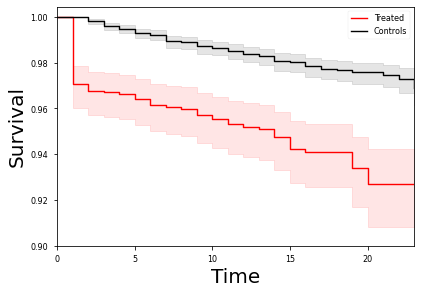

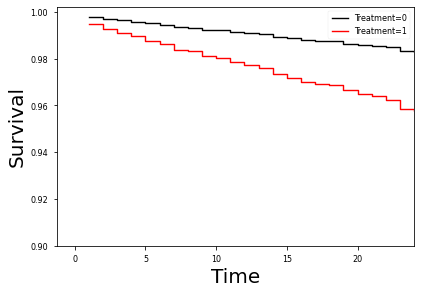

In [14]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [15]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       61.289191  4.927783e-15  47.527983

In [16]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               2.169           0.456        4.755    0.000
Total Cost                        0.001           0.028        0.020    0.984
Gender                            0.444           0.156        2.838    0.005
Tobacco Use                       0.039           0.233        0.168    0.867
Pressure                        -14.705        1066.654       -0.014    0.989
Obesity                           0.635           0.152        4.172    0.000
Hypertension                     -0.128           0.165       -0.777    0.437
Hypothyroid                      -0.218           0.230       -0.951    0.342
Disease Count                     2.668           0.637        4.190    0.000
Acute Care 2 Months               0.513           0.374        1.371    0.170
Acute Care 6 Months              -1.100           0.984       -1.118    0.264
Inpatient Visits 6 Months         0.186           0.785        0.237    0.812
Emergency Vistits 6 Months        1.144           0.924        1.237    0.216
Line of Bussiness                -0.337           0.316       -1.067    0.286
Treatment                         0.918           0.144        6.366    0.000

### ER

data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
treated.columns

Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTE

In [18]:
%%time
onset = 'ER_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, 
                                                 grace = grace, 
                                                 onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset,
                                                  grace = grace).reset_index(drop = True).dropna(axis = 0,subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 50.2 ms, total: 12.1 s
Wall time: 12.1 s


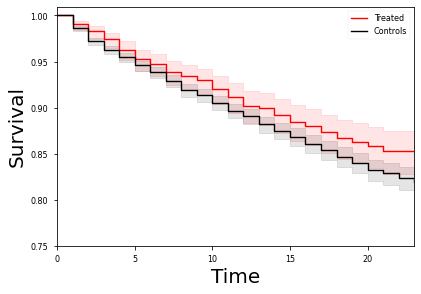

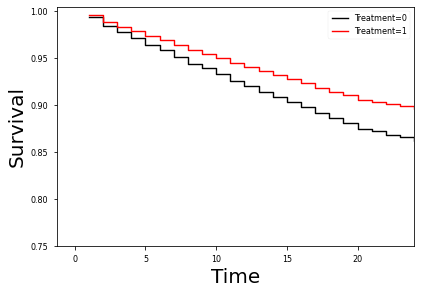

In [19]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.75]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [20]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        2.807795  0.093807  3.414157

In [21]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.592           0.202       -2.937    0.003
Total Cost                        0.064           0.013        4.927    0.000
Gender                           -0.089           0.085       -1.047    0.295
Tobacco Use                       0.309           0.095        3.250    0.001
Pressure                          1.112           0.363        3.065    0.002
Obesity                           0.073           0.070        1.032    0.302
Hypertension                      0.208           0.079        2.643    0.008
Hypothyroid                      -0.070           0.110       -0.639    0.523
Disease Count                     1.017           0.302        3.370    0.001
Acute Care 2 Months               1.166           0.128        9.140    0.000
Acute Care 6 Months               0.054           0.306        0.176    0.860
Inpatient Visits 6 Months        -0.410           0.245       -1.674    0.094
Emergency Vistits 6 Months        0.654           0.283        2.313    0.021
Line of Bussiness                -0.452           0.121       -3.737    0.000
Treatment                        -0.300           0.088       -3.410    0.001

### IP

data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.2 s, sys: 31.9 ms, total: 12.2 s
Wall time: 12.2 s


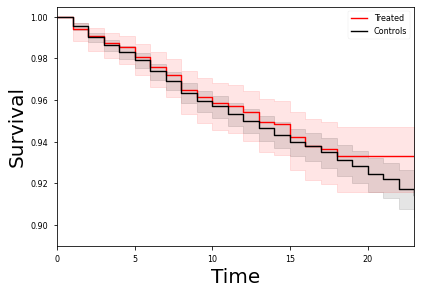

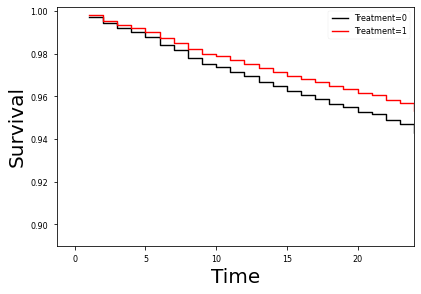

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.89]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [24]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits        0.392913  0.530772  0.913836

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               0.433           0.303        1.428    0.153
Total Cost                        0.147           0.021        6.998    0.000
Gender                            0.236           0.112        2.112    0.035
Tobacco Use                       0.316           0.137        2.305    0.021
Pressure                          0.155           0.517        0.300    0.764
Obesity                           0.281           0.100        2.817    0.005
Hypertension                      0.200           0.111        1.799    0.072
Hypothyroid                       0.075           0.144        0.524    0.600
Disease Count                     1.798           0.404        4.450    0.000
Acute Care 2 Months               0.866           0.185        4.689    0.000
Acute Care 6 Months              -0.845           0.342       -2.469    0.014
Inpatient Visits 6 Months         1.339           0.314        4.270    0.000
Emergency Vistits 6 Months        0.657           0.289        2.272    0.023
Line of Bussiness                -0.348           0.188       -1.852    0.064
Treatment                        -0.213           0.125       -1.707    0.088

### Acute Care IP OR ER

data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 37.7 ms, total: 12.1 s
Wall time: 12.1 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
4     2619378   3  1      0     0.0     0.0        1               78   
5     2621187  11  1      0     0.0     0.0        2               78   
6     2623521  28  1      0     0.0     0.0        0               77   
16    2651688   4  1      0     0.0     0.0        0               74   
26    2668219   5  1      0     0.0     0.0        0               71   
...       ...  .. ..    ...     ...     ...      ...              ...   
1330  4390059   4  1      0     0.0     0.0        0               47   
1334  4398341  11  1      0     0.0     0.0        0               66   
1337  5001236  16  1      0     0.0     0.0        0               60   
1342  5003200   1  1      1     1.0     1.0        1               55   
1348  5014675   3  1      0     0.0     0.0        1               26   

      ALLOW_AMT  ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4           399       0.0  ...       0      0.0      0.0     0    1         1   
5         13007       0.0  ...       0      0.0      0.0     0    1         1   
6             0       0.0  ...       0      0.0      0.0     0    1         0   
16          179       0.0  ...       0      0.0      0.0     0    1         1   
26          346       0.0  ...       0      0.0      0.0     0    1         0   
...         ...       ...  ...     ...      ...      ...   ...  ...       ...   
1330          2       0.0  ...       0      0.0      0.0     0    1         0   
1334          0       0.0  ...       0      0.0      0.0     0    1         0   
1337        374       0.0  ...       0      0.0      0.0     0    1         0   
1342       3137    1298.0  ...       0      0.0      0.0     0    1         0   
1348        409       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
26        Medicare  201911        0.0          1  
...            ...     ...        ...        ...  
1330    Commercial  202002        0.0          1  
1334      Medicare  202005        0.0          1  
1337    Commercial  202002        0.0          1  
1342    Commercial  202005        0.0          1  
1348    Commercial  202010        0.0          1  

[217 rows x 95 columns]

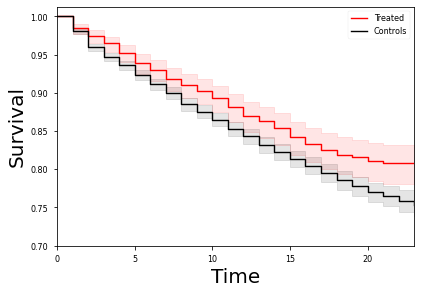

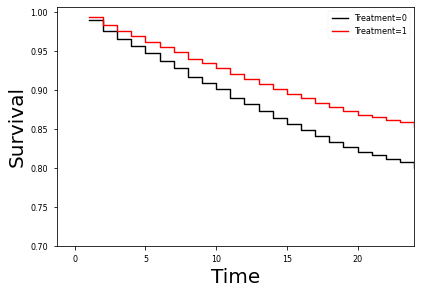

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [30]:
lrsumm

test_statistic         p  -log2(p)
Acute Care        6.648618  0.009923  6.654968

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.033           0.170       -6.079    0.000
Total Cost                        0.100           0.011        8.862    0.000
Gender                           -0.044           0.071       -0.619    0.536
Tobacco Use                       0.231           0.084        2.765    0.006
Pressure                          0.867           0.340        2.546    0.011
Obesity                           0.033           0.060        0.549    0.583
Hypertension                      0.262           0.067        3.917    0.000
Hypothyroid                      -0.006           0.092       -0.062    0.951
Disease Count                     0.951           0.259        3.678    0.000
Acute Care 2 Months               1.261           0.111       11.379    0.000
Acute Care 6 Months               0.416           0.250        1.663    0.096
Inpatient Visits 6 Months        -0.288           0.226       -1.274    0.203
Emergency Vistits 6 Months        0.106           0.232        0.455    0.649
Line of Bussiness                -0.278           0.109       -2.535    0.011
Treatment                        -0.337           0.075       -4.477    0.000

### Acute Care  diff and diff calculation

In [32]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle("../Pre_Matching_DATA/"+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls_all = pd.read_pickle(p+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 11.8 s, sys: 13.4 s, total: 25.1 s
Wall time: 49 s


In [33]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), controls_all.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

try:
    controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    controls2 = controls2
try:
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    treated2 = treated2
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
#for d in data2:
#    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 27.3 s, sys: 2.35 s, total: 29.6 s
Wall time: 29.6 s


In [34]:
treated2.shape, controls2.shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


In [35]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [36]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [37]:
%%time
times = [0]
onset = 'ACUTE'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.4 s, sys: 99.4 ms, total: 12.5 s
Wall time: 12.5 s


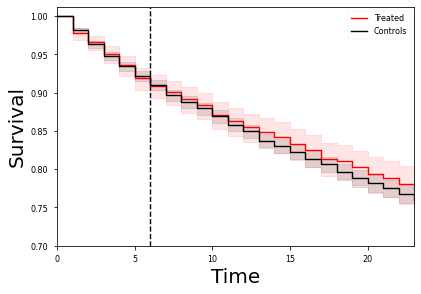

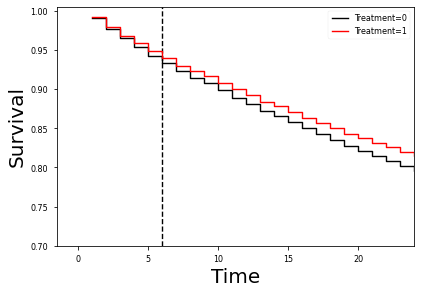

In [38]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [39]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd        0.996728  0.318103  1.652432

In [40]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.335           0.151       -2.215    0.027
Total Cost                        0.064           0.010        6.360    0.000
Gender                            0.108           0.061        1.767    0.077
Tobacco Use                       0.121           0.080        1.510    0.131
Pressure                          0.391           0.315        1.242    0.214
Obesity                           0.005           0.055        0.086    0.931
Hypertension                     -0.010           0.063       -0.161    0.872
Hypothyroid                      -0.179           0.087       -2.050    0.040
Disease Count                     1.702           0.242        7.020    0.000
Acute Care 2 Months               1.235           0.104       11.842    0.000
Acute Care 6 Months               0.594           0.264        2.251    0.024
Inpatient Visits 6 Months        -0.408           0.239       -1.709    0.087
Emergency Vistits 6 Months       -0.039           0.243       -0.159    0.874
Line of Bussiness                -0.558           0.092       -6.053    0.000
Treatment                        -0.105           0.066       -1.583    0.113

### Load all Log Rank Sums in a matrix

In [41]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [42]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      61.29                  0.00   
Emergency Visits               2.81                  0.09   
Inpatient Vistis               0.39                  0.53   
Acute Care                     6.65                  0.01   
Acute Care DD                  1.00                  0.32   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.15   
Emergency Visits                            0.04   
Inpatient Vistis                            0.00   
Acute Care                                  0.07   
Acute Care DD                              -0.00   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.33   
Emergency Visits                             0.12   
Inpatient Vistis                             0.02   
Acute Care                                   0.22   
Acute Care DD                                0.02   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.54   
Emergency Visits                             0.23   
Inpatient Vistis                             0.03   
Acute Care                                   0.39   
Acute Care DD                                0.07   

                  RMST Difference After 24 Months  
Diabetes                                    -0.80  
Emergency Visits                             0.38  
Inpatient Vistis                             0.09  
Acute Care                                   0.65  
Acute Care DD                                0.15